In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_h(x, y, t):
    return -torch.sin(x)*torch.sin(y)*torch.cos(t)

def initial_condition_h(x, y):
    return -torch.sin(x)*torch.sin(y) 

In [3]:
# Define the exact solution p = E
def exact_solution_e1(x, y, t):
    return -torch.sin(x)*torch.sin(t)*torch.cos(y)

def initial_condition_e1(x, y):
    return 0.0*torch.sin(x) 

In [4]:
# Define the exact solution p = E
def exact_solution_e2(x, y, t):
    return torch.sin(y)*torch.sin(t)*torch.cos(x)

def initial_condition_e2(x, y):
    return 0.0*torch.sin(x) 

In [5]:
# assigning number of points
initial_pts = 200 
left_boundary_pts = 200 
right_boundary_pts = 200
back_boundary_pts = 200
front_boundary_pts = 200
residual_pts = 1000

In [6]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

x_init = torch.rand((initial_pts,1)) # initial pts
y_init = torch.rand((initial_pts,1))
t_init =  0*x_init
init =  torch.cat([x_init, y_init, t_init],1)
h_init = initial_condition_h(init[:,0], init[:, 1]).reshape(-1, 1)
e1_init = initial_condition_e1(init[:,0], init[:, 1]).reshape(-1, 1)
e2_init = initial_condition_e2(init[:,0], init[:, 1]).reshape(-1, 1)
w_init = torch.cat([h_init, e1_init, e2_init],1)


xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
yb_left = torch.rand((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, yb_left, tb_left ],1)
h_b_l = exact_solution_h(xb_left, yb_left, tb_left).reshape(-1, 1)
e1_b_l = exact_solution_e1(xb_left, yb_left, tb_left).reshape(-1, 1)
e2_b_l = exact_solution_e2(xb_left, yb_left, tb_left).reshape(-1, 1)



xb_right = torch.ones((right_boundary_pts, 1)) # right spatial boundary
yb_right = torch.rand((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, yb_right, tb_right ],1)
h_b_r = exact_solution_h(xb_right, yb_right, tb_right).reshape(-1, 1)
e1_b_r = exact_solution_e1(xb_right, yb_right, tb_right).reshape(-1, 1)
e2_b_r = exact_solution_e2(xb_right, yb_right, tb_right).reshape(-1, 1)



xb_front = torch.rand((front_boundary_pts, 1)) # front spatial boundary
yb_front = torch.zeros((front_boundary_pts, 1)) # front spatial boundary
tb_front = torch.rand((front_boundary_pts, 1)) # 
b_front = torch.cat([xb_front, yb_front, tb_front ],1)
h_b_f = exact_solution_h(xb_front, yb_front, tb_front).reshape(-1, 1)
e1_b_f = exact_solution_e1(xb_front, yb_front, tb_front).reshape(-1, 1)
e2_b_f = exact_solution_e2(xb_front, yb_front, tb_front).reshape(-1, 1)



xb_back = torch.rand((back_boundary_pts, 1)) # back spatial boundary
yb_back = torch.ones((back_boundary_pts, 1)) # back spatial boundary
tb_back = torch.rand((back_boundary_pts, 1)) # back boundary pts
b_back = torch.cat([xb_back, yb_back, tb_back ],1)
h_b_b = exact_solution_h(xb_back, yb_back, tb_back).reshape(-1, 1)
e1_b_b = exact_solution_e1(xb_back, yb_back, tb_back).reshape(-1, 1)
e2_b_b = exact_solution_e2(xb_back, yb_back, tb_back).reshape(-1, 1)



x_interior = torch.rand((residual_pts, 1))
y_interior = torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, y_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right, b_front, b_back), batch_size=200, shuffle=False)

In [7]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [8]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1], n_hidden_layers=4, neurons=20)


In [9]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [10]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [11]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right, bd_front, bd_back) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                h_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                e1_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                e2_initial_pred_ = w_initial_pred_[:,2].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_h_ini = torch.autograd.grad(h_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                h_initial_t = grad_h_ini[:, 2]
                
                grad_e1_ini = torch.autograd.grad(e1_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                e1_initial_t = grad_e1_ini[:, 2]
                
                grad_e2_ini = torch.autograd.grad(e2_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                e2_initial_t = grad_e2_ini[:, 2]
                
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                h_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                e1_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                e2_bd_left_pred_ = w_bd_left_pred_[:,2].reshape(-1,1)
                
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                h_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                e1_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                e2_bd_right_pred_ = w_bd_right_pred_[:,2].reshape(-1,1)
                
                # for front boundary
                w_bd_front_pred_ = model(bd_front)
                h_bd_front_pred_ = w_bd_front_pred_[:,0].reshape(-1,1)
                e1_bd_front_pred_ = w_bd_front_pred_[:,1].reshape(-1,1)
                e2_bd_front_pred_ = w_bd_front_pred_[:,2].reshape(-1,1)
                
                # for back boundary
                w_bd_back_pred_ = model(bd_back)
                h_bd_back_pred_ = w_bd_back_pred_[:,0].reshape(-1,1)
                e1_bd_back_pred_ = w_bd_back_pred_[:,1].reshape(-1,1)
                e2_bd_back_pred_ = w_bd_back_pred_[:,2].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                h_hat = w_hat[:,0].reshape(-1,1)
                e1_hat = w_hat[:,1].reshape(-1,1)
                e2_hat = w_hat[:,2].reshape(-1,1)
                
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                
                grad_h_hat = torch.autograd.grad(h_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                h_x = grad_h_hat[:, 0].reshape(-1,1)
                h_y = grad_h_hat[:, 1].reshape(-1,1)
                
                grad_e1_hat = torch.autograd.grad(e1_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                e1_x = grad_e1_hat[:, 0].reshape(-1,1)
                e1_y = grad_e1_hat[:, 1].reshape(-1,1)
                
                grad_e2_hat = torch.autograd.grad(e2_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                e2_x = grad_e2_hat[:, 0].reshape(-1,1)
                e2_y = grad_e2_hat[:, 1].reshape(-1,1)
                
                h_t = grad_h_hat[:, 2].reshape(-1,1)
                e1_t = grad_e1_hat[:, 2].reshape(-1,1)
                e2_t = grad_e2_hat[:, 2].reshape(-1,1)
                
                
                # Item 1. below
                loss1 = torch.mean((h_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + torch.mean((2*h_t.reshape(-1, ) + e2_x.reshape(-1, ) - e1_y.reshape(-1, ))**p)+torch.mean((h_bd_left_pred_.reshape(-1,)- h_b_l.reshape(-1,))**p) + torch.mean((h_bd_right_pred_.reshape(-1,)- h_b_r.reshape(-1,))**p) +torch.mean((h_bd_front_pred_.reshape(-1,)- h_b_f.reshape(-1,))**p) + torch.mean((h_bd_back_pred_.reshape(-1,)- h_b_b.reshape(-1,))**p)
                loss2 = torch.mean((e1_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((4*e1_t.reshape(-1, ) + 2*e2_t.reshape(-1, ) - h_y.reshape(-1, ) + 3*torch.sin(interior[:, 0])*torch.cos(interior[:, 2])*torch.cos(interior[:, 1]) - 2*torch.cos(interior[:, 0])*torch.cos(interior[:, 2])*torch.sin(interior[:, 1]) )**p) +torch.mean((e1_bd_left_pred_.reshape(-1,)- e1_b_l.reshape(-1,))**p) + torch.mean((e1_bd_right_pred_.reshape(-1,)- e1_b_r.reshape(-1,))**p) +torch.mean((e1_bd_front_pred_.reshape(-1,)- e1_b_f.reshape(-1,))**p) + torch.mean((e1_bd_back_pred_.reshape(-1,)- e1_b_b.reshape(-1,))**p)
                loss3 = torch.mean((e2_initial_pred_.reshape(-1, ) - w_initial[:,2].reshape(-1, ))**p)+ torch.mean((2*e1_t.reshape(-1, ) + e2_t.reshape(-1, )  + h_x.reshape(-1, ) + 2*torch.sin(interior[:, 0])*torch.cos(interior[:, 2])*torch.cos(interior[:, 1]))**p) +torch.mean((e2_bd_left_pred_.reshape(-1,)- e2_b_l.reshape(-1,))**p) + torch.mean((e2_bd_right_pred_.reshape(-1,)- e2_b_r.reshape(-1,))**p) +torch.mean((e2_bd_front_pred_.reshape(-1,)- e2_b_f.reshape(-1,))**p) + torch.mean((e2_bd_back_pred_.reshape(-1,)- e2_b_b.reshape(-1,))**p)
                loss = loss1 + loss2 + loss3
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [12]:
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  196.6463165283203
################################  1  ################################
Loss:  192.28948974609375
################################  2  ################################
Loss:  164.31683349609375
################################  3  ################################
Loss:  135.86630249023438
################################  4  ################################
Loss:  108.77497100830078
################################  5  ################################
Loss:  86.24449157714844
################################  6  ################################
Loss:  69.90144348144531
################################  7  ################################
Loss:  58.81214141845703
################################  8  ################################
Loss:  50.9391975402832
################################  9  ################################
Loss:  44.75000762939453
################################  10  #########

Loss:  0.04279445484280586
################################  88  ################################
Loss:  0.040860891342163086
################################  89  ################################
Loss:  0.03894087299704552
################################  90  ################################
Loss:  0.036927130073308945
################################  91  ################################
Loss:  0.03502443805336952
################################  92  ################################
Loss:  0.03323056176304817
################################  93  ################################
Loss:  0.03150361776351929
################################  94  ################################
Loss:  0.029864724725484848
################################  95  ################################
Loss:  0.028326090425252914
################################  96  ################################
Loss:  0.026864327490329742
################################  97  ################################
Loss:  0.025508

Loss:  0.00406262930482626
################################  177  ################################
Loss:  0.0040251724421978
################################  178  ################################
Loss:  0.0039874785579741
################################  179  ################################
Loss:  0.003950648941099644
################################  180  ################################
Loss:  0.003913928754627705
################################  181  ################################
Loss:  0.0038787415251135826
################################  182  ################################
Loss:  0.0038430853746831417
################################  183  ################################
Loss:  0.0038061211816966534
################################  184  ################################
Loss:  0.003769475035369396
################################  185  ################################
Loss:  0.0037313513457775116
################################  186  ################################
L

Loss:  0.0017938273958861828
################################  264  ################################
Loss:  0.0017841203371062875
################################  265  ################################
Loss:  0.0017743487842381
################################  266  ################################
Loss:  0.0017646192573010921
################################  267  ################################
Loss:  0.0017551779747009277
################################  268  ################################
Loss:  0.0017459912924095988
################################  269  ################################
Loss:  0.0017369843553751707
################################  270  ################################
Loss:  0.001727718859910965
################################  271  ################################
Loss:  0.0017189253121614456
################################  272  ################################
Loss:  0.0017108164029195905
################################  273  ###########################

Loss:  0.0011403145035728812
################################  354  ################################
Loss:  0.0011359868803992867
################################  355  ################################
Loss:  0.0011317820753902197
################################  356  ################################
Loss:  0.001127599272876978
################################  357  ################################
Loss:  0.0011234432458877563
################################  358  ################################
Loss:  0.001119287800975144
################################  359  ################################
Loss:  0.0011150968493893743
################################  360  ################################
Loss:  0.0011109933257102966
################################  361  ################################
Loss:  0.0011071809567511082
################################  362  ################################
Loss:  0.0011035498464480042
################################  363  #########################

Loss:  0.0008213041583076119
################################  448  ################################
Loss:  0.0008183374302461743
################################  449  ################################
Loss:  0.0008154223905876279
################################  450  ################################
Loss:  0.0008124979212880135
################################  451  ################################
Loss:  0.0008098697871901095
################################  452  ################################
Loss:  0.0008074123179540038
################################  453  ################################
Loss:  0.0008051128825172782
################################  454  ################################
Loss:  0.0008029680466279387
################################  455  ################################
Loss:  0.00080095324665308
################################  456  ################################
Loss:  0.000799048226326704
################################  457  ##########################

Loss:  0.0006184374215081334
################################  538  ################################
Loss:  0.0006167255342006683
################################  539  ################################
Loss:  0.0006148769753053784
################################  540  ################################
Loss:  0.0006130102556198835
################################  541  ################################
Loss:  0.0006113244453445077
################################  542  ################################
Loss:  0.00060963851865381
################################  543  ################################
Loss:  0.0006077965954318643
################################  544  ################################
Loss:  0.0006060151499696076
################################  545  ################################
Loss:  0.0006041208980605006
################################  546  ################################
Loss:  0.0006023087771609426
################################  547  #########################

Loss:  0.00045686354860663414
################################  641  ################################
Loss:  0.0004557412466965616
################################  642  ################################
Loss:  0.0004545446136035025
################################  643  ################################
Loss:  0.00045339332427829504
################################  644  ################################
Loss:  0.0004522051603998989
################################  645  ################################
Loss:  0.0004509609716478735
################################  646  ################################
Loss:  0.00044972082832828164
################################  647  ################################
Loss:  0.00044846738455817103
################################  648  ################################
Loss:  0.0004472479922696948
################################  649  ################################
Loss:  0.0004459668998606503
################################  650  ###################

Loss:  0.0003713528858497739
################################  738  ################################
Loss:  0.00037070695543661714
################################  739  ################################
Loss:  0.0003700446686707437
################################  740  ################################
Loss:  0.0003693391918204725
################################  741  ################################
Loss:  0.000368517532479018
################################  742  ################################
Loss:  0.0003678131033666432
################################  743  ################################
Loss:  0.0003671487793326378
################################  744  ################################
Loss:  0.00036629950045607984
################################  745  ################################
Loss:  0.0003654603206086904
################################  746  ################################
Loss:  0.00036461176932789385
################################  747  #####################

Loss:  0.000297053309623152
################################  837  ################################
Loss:  0.0002965816529467702
################################  838  ################################
Loss:  0.0002960906131193042
################################  839  ################################
Loss:  0.0002956123207695782
################################  840  ################################
Loss:  0.0002951574861072004
################################  841  ################################
Loss:  0.00029471656307578087
################################  842  ################################
Loss:  0.0002942620776593685
################################  843  ################################
Loss:  0.00029370986158028245
################################  844  ################################
Loss:  0.00029326402000151575
################################  845  ################################
Loss:  0.0002927597379311919
################################  846  #####################

Loss:  0.0002578214625827968
################################  920  ################################
Loss:  0.0002574523095972836
################################  921  ################################
Loss:  0.00025706368614919484
################################  922  ################################
Loss:  0.0002566611219663173
################################  923  ################################
Loss:  0.0002562707813922316
################################  924  ################################
Loss:  0.00025587715208530426
################################  925  ################################
Loss:  0.000255503982771188
################################  926  ################################
Loss:  0.00025512356660328805
################################  927  ################################
Loss:  0.0002547321782913059
################################  928  ################################
Loss:  0.000254322774708271
################################  929  ######################

Loss:  0.00022677633387502283
################################  1004  ################################
Loss:  0.00022639642702415586
################################  1005  ################################
Loss:  0.00022602785611525178
################################  1006  ################################
Loss:  0.00022565828112419695
################################  1007  ################################
Loss:  0.0002252760750707239
################################  1008  ################################
Loss:  0.00022490849369205534
################################  1009  ################################
Loss:  0.00022453852579928935
################################  1010  ################################
Loss:  0.00022417213767766953
################################  1011  ################################
Loss:  0.00022382489987649024
################################  1012  ################################
Loss:  0.00022348255151882768
################################  1013  ####

Loss:  0.00019328019698150456
################################  1093  ################################
Loss:  0.00019287955365143716
################################  1094  ################################
Loss:  0.0001924909302033484
################################  1095  ################################
Loss:  0.000192109466297552
################################  1096  ################################
Loss:  0.00019173948385287076
################################  1097  ################################
Loss:  0.0001913661981234327
################################  1098  ################################
Loss:  0.00019098141638096422
################################  1099  ################################
Loss:  0.00019053780124522746
################################  1100  ################################
Loss:  0.000190089107491076
################################  1101  ################################
Loss:  0.0001897006295621395
################################  1102  ##########

Loss:  0.0001607901358511299
################################  1185  ################################
Loss:  0.0001605426223250106
################################  1186  ################################
Loss:  0.00016033087740652263
################################  1187  ################################
Loss:  0.00016012362902984023
################################  1188  ################################
Loss:  0.00015988264931365848
################################  1189  ################################
Loss:  0.00015965836064424366
################################  1190  ################################
Loss:  0.00015943366452120245
################################  1191  ################################
Loss:  0.00015917536802589893
################################  1192  ################################
Loss:  0.00015895834076218307
################################  1193  ################################
Loss:  0.00015872457879595459
################################  1194  #####

Loss:  0.00014167760673444718
################################  1277  ################################
Loss:  0.00014143709267955273
################################  1278  ################################
Loss:  0.00014119414845481515
################################  1279  ################################
Loss:  0.0001409510732628405
################################  1280  ################################
Loss:  0.00014070890028961003
################################  1281  ################################
Loss:  0.00014047457079868764
################################  1282  ################################
Loss:  0.00014023997937329113
################################  1283  ################################
Loss:  0.00014000956434756517
################################  1284  ################################
Loss:  0.00013978444621898234
################################  1285  ################################
Loss:  0.00013956136535853148
################################  1286  ####

Loss:  0.00012199066986795515
################################  1370  ################################
Loss:  0.00012179017357993871
################################  1371  ################################
Loss:  0.00012161278573330492
################################  1372  ################################
Loss:  0.00012143145431764424
################################  1373  ################################
Loss:  0.00012123113265261054
################################  1374  ################################
Loss:  0.00012101084575988352
################################  1375  ################################
Loss:  0.00012074812548235059
################################  1376  ################################
Loss:  0.00012056071864208207
################################  1377  ################################
Loss:  0.00012034475366817787
################################  1378  ################################
Loss:  0.00012012758088530973
################################  1379  ###

Loss:  0.00010566492710495368
################################  1465  ################################
Loss:  0.00010550056322244927
################################  1466  ################################
Loss:  0.00010532572923693806
################################  1467  ################################
Loss:  0.0001051775980158709
################################  1468  ################################
Loss:  0.00010503552766749635
################################  1469  ################################
Loss:  0.00010487993131391704
################################  1470  ################################
Loss:  0.00010473511065356433
################################  1471  ################################
Loss:  0.00010459132317919284
################################  1472  ################################
Loss:  0.00010446239321026951
################################  1473  ################################
Loss:  0.0001043374722939916
################################  1474  #####

In [13]:
# saving and loading Model
FILE = "maxwell2D_4.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [14]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [15]:
x_test = torch.linspace(0, 1, 10000).reshape(-1,1)
y_test = torch.linspace(0, 1, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, y_test, t_test],1)
h_test = exact_solution_h(x_test, y_test, t_test).reshape(-1,1)
e1_test = exact_solution_e1(x_test, y_test, t_test).reshape(-1,1)
e2_test = exact_solution_e2(x_test, y_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
h_test_pred = w_test_pred[:,0].reshape(-1,1)
e1_test_pred = w_test_pred[:,1].reshape(-1,1)
e2_test_pred = w_test_pred[:,2].reshape(-1,1)

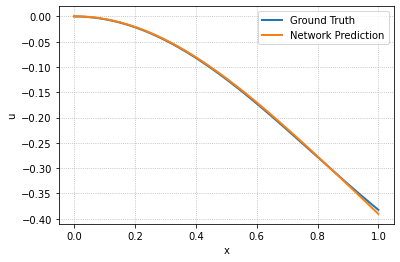

In [16]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, h_test, label="Ground Truth",lw=2)
plt.plot(x_test, h_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [17]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((h_test_pred - h_test)**2)/torch.mean(h_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.012244652316439897 %


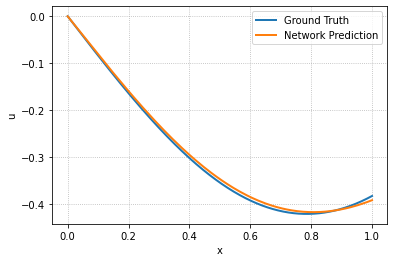

In [18]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, e1_test, label="Ground Truth",lw=2)
plt.plot(x_test, e1_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [19]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((e1_test_pred - e1_test)**2)/torch.mean(e1_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.028270622715353966 %


In [20]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((e2_test_pred - e2_test)**2)/torch.mean(e2_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.11833346216008067 %


In [21]:
# for ploting

In [22]:
model = my_network
x_test = pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)

u_pred1 = u_test_pred[:, 1].reshape(-1,1)


relative_error = torch.abs(u_pred- u_test)

relative_error1 = torch.abs(u_pred1- p_test)
u_pred = u_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
p_pred = u_pred1.detach().numpy()
relative_error = relative_error.detach().numpy()
relative_error1 = relative_error1.detach().numpy()

NameError: name 'exact_solution_u' is not defined

In [ ]:

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)

In [ ]:

plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, u_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#plt.savefig('timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
CS = plt.tricontourf(x_test, t_test, p_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('timo_p.png', dpi = 300, bbox_inches = "tight")

In [ ]:

x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)




CS = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
relative_error1 = relative_error1.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error1, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_p.png', dpi = 300, bbox_inches = "tight")